In [1]:
import pandas as pd
import numpy as np




In [2]:
# define method of discover revolution
from pandas import Series
from scipy import stats
from scipy.stats import norm
import math
def sens_slope_trend_detection(inputdata,conf_level=0.95):
    inputdata = Series(inputdata)
    n  = inputdata.shape[0]
    t  = inputdata.value_counts()
    tadjs = sum(t * (t - 1) * (2 * t + 5))
    varS = (n * (n - 1) * (2 * n + 5) - tadjs)/18.0
    k = 0
    d = []
    for i in range(n-1):
        for j in range(i+1,n):
            k = k+1
            d.append((inputdata[j]*1.0 - inputdata[i])/(j - i))
    b_sen = np.median(d)
    C = norm.ppf(1 - (1 - conf_level)/2.0) * np.sqrt(varS)
    rank_up = int(round((k + C)/2.0 + 1))
    rank_lo = int(round((k - C)/2.0))
    rank_d = sorted(d)
    lo = rank_d[rank_lo - 1]
    up = rank_d[rank_up - 1]
    S = 0
    for m in range(n):
        S = S + np.sum(np.sign(inputdata[m] - inputdata[0:m+1]))
    sg = np.sign(S)
    z = sg * (np.abs(S) - 1.0)/np.sqrt(varS)
    pval = 2 * min(0.5, 1-norm.cdf(np.abs(z)))
    return b_sen,z,pval


# mann-kendall

def Kendall_change_point_detection(inputdata):
    inputdata = np.array(inputdata)
    n=inputdata.shape[0]
    Sk             = [0]
    UFk            = [0]
    s              =  0
    Exp_value      = [0]
    Var_value      = [0]
    for i in range(1,n):
        for j in range(i):
            if inputdata[i] > inputdata[j]:
                s = s+1
            else:
                s = s+0
        Sk.append(s)
        Exp_value.append((i+1)*(i+2)/4.0 )                     # Sk[i]的均值
        Var_value.append((i+1)*i*(2*(i+1)+5)/72.0 )            # Sk[i]的方差
        UFk.append((Sk[i]*1.0-Exp_value[i])/np.sqrt(Var_value[i]))
    Sk2             = [0]
    UBk             = [0]
    UBk2            = [0]
    s2              =  0
    Exp_value2      = [0]
    Var_value2      = [0]
    inputdataT = list(reversed(inputdata))
    for i in range(1,n):
        for j in range(i):
            if inputdataT[i] > inputdataT[j]:
                s2 = s2+1
            else:
                s2 = s2+0
        Sk2.append(s2)
        Exp_value2.append((i+1)*(i+2)/4.0)                     # Sk[i]的均值
        Var_value2.append((i+1)*i*(2*(i+1)+5)/72.0 )            # Sk[i]的方差
        UBk.append((Sk2[i]*1.0-Exp_value2[i])/np.sqrt(Var_value2[i]))
        UBk2.append(-UBk[i])
    UBkT = list(reversed(UBk2))
    diff = np.array(UFk) - np.array(UBkT)
    K    = list()
    for k in range(1,n):
        if diff[k-1]*diff[k]<0:
            K.append(k)
    return K


# Pettitt

def Pettitt_change_point_detection(inputdata):
    inputdata = np.array(inputdata)
    n         = inputdata.shape[0]
    k = range(n)
    inputdataT = pd.Series(inputdata)
    r = inputdataT.rank()
    Uk = [2*np.sum(r[0:x])-x*(n + 1) for x in k]
    Uka = list(np.abs(Uk))
    U = np.max(Uka)
    K = Uka.index(U)
    pvalue         = 2.0 * np.exp((-6.0 * (U**2))/(n**3 + n**2))
    if pvalue <= 0.05:
        change_point_desc = u'显著'
    else:
        change_point_desc = u'不显著'
    #Pettitt_result = {'突变点位置':K,'突变程度':change_point_desc}
    return K #,Pettitt_result


# Buishand U test

def Buishand_U_change_point_detection(inputdata):
    inputdata = np.array(inputdata)
    inputdata_mean = np.mean(inputdata)
    n  = inputdata.shape[0]
    k = range(n)
    Sk = [np.sum(inputdata[0:x+1] - inputdata_mean) for x in k]
    sigma = np.sqrt(np.sum((inputdata-(np.mean(inputdata))*1.0)**2)/(n-1))
    U = np.sum((Sk[0:(n - 2)]/(sigma*1.8))**2)/(n * (n + 1))
    Ska = np.abs(Sk)
    S = np.max(Ska)
    K = list(Ska).index(S) + 1
    Skk = (Sk/(sigma*1.0))
    return K


# Standard Normal Homogeneity Test (SNHT)

def SNHT_change_point_detection(inputdata):
    inputdata = np.array(inputdata)
    inputdata_mean = np.mean(inputdata)
    n  = inputdata.shape[0]
    k = range(1,n)
    sigma = np.sqrt(np.sum((inputdata-(np.mean(inputdata))*1.0)**2)/(n-1))
    Tk = [x*(np.sum((inputdata[0:x]-inputdata_mean)/(sigma*1.0))/x)**2 + (n-x)*(np.sum((inputdata[x:n]-inputdata_mean)/(sigma*1.0))/(n-x))**2 for x in k]
    T = np.max(Tk)
    K = list(Tk).index(T) + 1
    return K


# change degree

def temp_trend_desc(change_rate):
    change_degree = (math.atan(change_rate))*180.0/math.pi
    if change_rate > 0:
        result_desc = '上升'
    elif change_rate < 0:
        result_desc = '下降'
    else:
        result_desc = u'稳定'
    change_degree = round(change_degree,2)
    return change_degree,result_desc


# simple linear trend degree (0-1 standardized rawdata)

def simple_linear_trend(inputdata,conf_level=0.95):
    # clf_result = [slope, intercept, r_value, p_value, std_err]
    inputdataT = (np.array(inputdata)-np.min(inputdata))/(np.max(inputdata)-np.min(inputdata))
    x = list(range(1,len(inputdata)+1))
    xT = 1.0*(np.array(x)-np.min(x))/(np.max(x)-np.min(x))
    clf_result = stats.linregress(xT,inputdataT)
    linearTrendDegree = clf_result[0]
    p_value = clf_result[3]
    p_value = round(p_value,3)
    intercept = clf_result[1]
    stderr = clf_result[-1]
    r_squared = clf_result[2]**2
    # diff1 = inputdataT[0:-1] - inputdataT[1:]
    # if sum(np.abs(diff1)>0.3)
    return linearTrendDegree,p_value,intercept,stderr,r_squared,x,xT,inputdataT


# linear trend degree (0-1 standardized rawdata)

def linear_trend_degree(inputdata,conf_level=0.95):
    # clf_result = [slope, intercept, r_value, p_value, std_err]
    if np.max(inputdata) > np.min(inputdata):
        linear_model_result = simple_linear_trend(inputdata,conf_level=0.95)
        linearTrendDegree = linear_model_result[0]
        p_value = linear_model_result[1]
        intercept = linear_model_result[2]
        stderr = linear_model_result[3]
        r_squared = linear_model_result[4]
        x = linear_model_result[5]
        xT = linear_model_result[6]
        inputdataT = linear_model_result[-1]
        fatal_point = []
        for xi in x:
            y_up   = linearTrendDegree*xT[xi-1] + intercept + 3*stderr
            y_down = linearTrendDegree*xT[xi-1] + intercept - 3*stderr
            if inputdataT[xi-1]>y_up or inputdataT[xi-1]<y_down:
                fatal_point.append(xi-1)
            else:
                pass
        # print(fatal_point)
        if fatal_point:
            xT = list(xT)
            inputdataT = list(inputdataT)
            for index in sorted(fatal_point, reverse=True):
                del xT[index]
                del inputdataT[index]
            xT = np.array(xT)
            inputdataT = np.array(inputdataT)
            clf_result = stats.linregress(xT,inputdataT)
            linearTrendDegree = clf_result[0]
            r_squared = clf_result[2]**2
            p_value = clf_result[3]
            p_value = round(p_value,3)
        else:
            pass
    else:
        linearTrendDegree = 0
        p_value = 0.000
        r_squared = 1
    return linearTrendDegree,p_value,r_squared


# desc begin

def trend_desc(inputdata,conf_level=0.95):
    global final_desc
    overall_num = len(inputdata)
    # Sen's slope
    trend_result = sens_slope_trend_detection(inputdata,conf_level)
    # trend desc
    change_rate = trend_result[0]
    linear_result = linear_trend_degree(inputdata)
    overall_change_degree = temp_trend_desc(linear_result[0])
    if linear_result[0] < 0:
        overall_trend = '下降'
    elif linear_result[0] > 0:
        overall_trend = '上升'
    else:
        overall_trend = '无显著线性趋势'
    # begin
    if np.abs(overall_change_degree[0]) > 10:
        trend_degree_desc = '大幅'
    else:
        trend_degree_desc = '小幅'
    # 满足R方>0.7且p值通过检验的，只做线性回归分析
    if linear_result[1] < 0.05 and linear_result[-1] > 0.7:
        final_desc = {'整体趋势':[trend_degree_desc + overall_trend],
                      '整体变化角度':[overall_change_degree[0]],
                      '突变点个数':['-'],
                      '突变点位置':['-'],
                      'Mann-Kendall突变位置':['-'] ,
                      'Pettitt突变位置':['-'] ,
                      'Buishand_U突变位置':['-'] ,
                      'SNHT突变位置':['-'] ,
                      '详情':['-']}
    # 不满足上述条件的，需要进行阶段性分析：突变点分析，整体波动性大小分析
    else:
        # overall trend desc (wave)
        # four change point methods
        Kendall_change_point_result    = Kendall_change_point_detection(inputdata)
        Pettitt_change_point_result    = Pettitt_change_point_detection(inputdata)
        Buishand_U_change_point_result = Buishand_U_change_point_detection(inputdata)
        SNHT_change_point_result       = SNHT_change_point_detection(inputdata)
        # Logical determination of change point
        temp_result = Kendall_change_point_result + [Pettitt_change_point_result, Buishand_U_change_point_result, SNHT_change_point_result]
        # Volatility description（波动性大分为两种情况：1、多波；2、少波但波动幅度大）
        inputdataT = (np.array(inputdata)-np.min(inputdata))/(np.max(inputdata)-np.min(inputdata))
        diff1 = inputdataT[0:-1] - inputdataT[1:]
        if (sum(np.abs(diff1)>0.3) >= 3) or (sum(np.abs(diff1)>0.4) >= 1):
            overall_wave = '大波动'
        else:
            overall_wave = '小波动'
        # Calculate the trend degree of each segment.
        # desc begin
        if Kendall_change_point_result==[]:
            final_desc = {'整体趋势':[overall_wave + trend_degree_desc + overall_trend],
                          '整体变化角度':[overall_change_degree[0]],
                          '突变点个数':['-'],
                          '突变点位置':['-'],
                          'Mann-Kendall突变位置':['-'] ,
                          'Pettitt突变位置':['-'] ,
                          'Buishand_U突变位置':['-'] ,
                          'SNHT突变位置':['-'] ,
                          '详情':['-']}
        else:
            temp_change_point_listT = np.array(temp_result)
            temp_change_point_list = list(temp_change_point_listT[temp_change_point_listT > 2])
            temp_change_point_list = list(set(temp_change_point_list))
            temp_change_point_list.sort()
            delete_aj = []
            for i in range(len(temp_change_point_list) - 1):
                for j in range(i+1,len(temp_change_point_list)):
                    temp_ij = np.abs(temp_change_point_list[j]-temp_change_point_list[i])
                    if temp_ij <=5:
                        delete_aj.append(temp_change_point_list[j])
                temp_change_point_list = [x for x in temp_change_point_list if x not in delete_aj]
            change_point_list = temp_change_point_list
            change_point_num = len(change_point_list)
            if change_point_num <= 2:
                if change_point_num == 1:
                    first_trend_desc01  = simple_linear_trend(inputdata[:change_point_list[0]-1],conf_level)
                    first_trend_desc1 = temp_trend_desc(first_trend_desc01[0])
                    second_trend_desc02  = simple_linear_trend(inputdata[change_point_list[0]:],conf_level)
                    second_trend_desc2 = temp_trend_desc(second_trend_desc02[0])
                    second_num = overall_num - change_point_list[0]
                    first_change_degree = first_trend_desc1[0]
                    first_change_trend = first_trend_desc1[1]
                    second_change_degree = second_trend_desc2[0]
                    second_change_trend = second_trend_desc2[1]
                    final_desc = {'整体趋势':[overall_wave + trend_degree_desc + overall_trend],
                                  '整体变化角度':[overall_change_degree[0]],
                                  '突变点个数':[change_point_num],
                                  '突变点位置':change_point_list,
                                  'Mann-Kendall突变位置':Kendall_change_point_result ,
                                  'Pettitt突变位置':[Pettitt_change_point_result] ,
                                  'Buishand_U突变位置':[Buishand_U_change_point_result] ,
                                  'SNHT突变位置':[SNHT_change_point_result] ,
                                  '详情':[{'第一段趋势':{'变化角度':first_change_degree,'趋势':first_change_trend},
                                  '第二段趋势':{'变化角度':second_change_degree,'趋势':second_change_trend}}]}
                elif change_point_num == 2:
                    first_trend_desc01  = simple_linear_trend(inputdata[:change_point_list[0]-1],conf_level)
                    first_trend_desc1 = temp_trend_desc(first_trend_desc01[0])
                    second_trend_desc02  = simple_linear_trend(inputdata[change_point_list[0]:change_point_list[1]-1],conf_level)
                    second_trend_desc2 = temp_trend_desc(second_trend_desc02[0])
                    third_trend_desc03  = simple_linear_trend(inputdata[change_point_list[1]:],conf_level)
                    third_trend_desc3 = temp_trend_desc(third_trend_desc03[0])
                    second_num = overall_num - change_point_list[0] - 1
                    third_num = overall_num - change_point_list[1]
                    first_change_degree = first_trend_desc1[0]
                    first_change_trend = first_trend_desc1[1]
                    second_change_degree = second_trend_desc2[0]
                    second_change_trend = second_trend_desc2[1]
                    third_change_degree = third_trend_desc3[0]
                    third_change_trend = third_trend_desc3[1]
                    final_desc = {'整体趋势':[overall_wave + trend_degree_desc + overall_trend],
                                  '整体变化角度':[overall_change_degree[0]],
                                  '突变点个数':[change_point_num],
                                  '突变点位置':change_point_list,
                                  'Mann-Kendall突变位置':Kendall_change_point_result ,
                                  'Pettitt突变位置':[Pettitt_change_point_result] ,
                                  'Buishand_U突变位置':[Buishand_U_change_point_result] ,
                                  'SNHT突变位置':[SNHT_change_point_result] ,
                                  '详情':[{'第一段趋势':{'变化角度':first_change_degree,'趋势':first_change_trend},
                                  '第二段趋势':{'变化角度':second_change_degree,'趋势':second_change_trend},
                                  '第三段趋势':{'变化角度':third_change_degree,'趋势':third_change_trend}}]}
            else:
                final_desc = {'整体趋势':[overall_wave + trend_degree_desc + overall_trend],
                              '变化角度':[overall_change_degree[0]],
                              '突变点个数':[change_point_num],
                              '突变点位置':change_point_list,
                              'Mann-Kendall突变位置':Kendall_change_point_result ,
                              'Pettitt突变位置':[Pettitt_change_point_result] ,
                              'Buishand_U突变位置':[Buishand_U_change_point_result] ,
                              'SNHT突变位置':[SNHT_change_point_result] ,
                              '详情':['-']}
    # final_desc = pd.DataFrame(final_desc,index=[0])
    return final_desc

In [61]:
# one year stop to process data for revelution calculate
one_year_stop_df=pd.read_csv(r'datanew/genre_one_year_stop5_2.csv')
one_year_stop_revolution=one_year_stop_df
one_year_stop_revolution.insert(0,'one_year_revolution','')
columns=list(one_year_stop_revolution.columns)
# NaN in first line of each genre should be replaced by 0
for index,row in one_year_stop_revolution.iterrows():
    if row['year']==1921:
        # one_year_stop_df.iloc[[index]].fillna(0,inplace=True)
        # one_year_stop_df.iloc[index].apply(lambda x: 0 if pd.isnull(x) else x,0)
        for i in range(2,len(columns)):
            if pd.isnull(one_year_stop_revolution.iloc[[index],[i]].values[0]):
                one_year_stop_revolution.iloc[[index],[i]]=0
#avoid SettingwithCopyWarning
nan2zerolist=['artists_num','music_num']
# feature about influence should be replaced by 0
for index in nan2zerolist:
    one_year_stop_revolution[index].fillna(0,inplace=True)
nan2padlist=['acousticness','danceability','duration_ms','energy','explicit','instrumentalness','key','liveness','loudness','mode','popularity','speechiness','tempo','valence']
#feature about music should be replaced by last one
for index in nan2padlist:
    one_year_stop_revolution[index].fillna(method='pad',inplace=True)
one_year_stop_revolution.head()

,one_year_revolution,music_genre,year,acousticness,artists_num,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,music_num,popularity,speechiness,tempo,valence
0,,None,1921,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000
1,,None,1922,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000
2,,None,1923,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000
3,,None,1924,0.761692,1.0,0.621462,227663.615385,0.363077,0.0,0.063595,5.230769,0.138731,-11.740077,0.846154,13.0,0.384615,0.0511,119.218615,0.649923
4,,None,1925,0.945000,2.0,0.804000,209987.000000,0.217000,0.0,0.068700,0.000000,0.084900,-12.118000,1.000000,1.0,18.000000,0.0602,131.117000,0.498000


In [62]:
# one year stop to get revolution
one_year_stop_revolution=one_year_stop_revolution.set_index(['music_genre','year'])
genre_group_one=one_year_stop_revolution.groupby('music_genre')
all_group_answers=[]
for name,group in genre_group_one:
    print(name)
    if name=="['Vocal']":
        for colname,column in group.iteritems():
            if colname!='one_year_revolution':
                answer=trend_desc(column)
                all_group_answers.append(answer.copy())
        change_point_times=np.zeros(100)
        for answer in all_group_answers:
            for point in answer['突变点位置']:
                if point!='-':
                    change_point_times[point]=change_point_times[point]+1
        for i in range(len(change_point_times)):
            revolutiontime=i+1921
            one_year_stop_revolution.loc[(name,revolutiontime),'one_year_revolution']=change_point_times[i]
            if change_point_times[i]>=3:
                print('{} is revolution, its {} features are judged as revolution'.format(revolutiontime,int(change_point_times[i])))
print(all_group_answers)

None
["Children's"]
['Avant-Garde']
['Blues']
['Classical']
['Comedy/Spoken']
['Country']
['Easy Listening']
['Electronic']
['Folk']
['International']
['Jazz']
['Latin']
['New Age']
['Pop/Rock']
['R&B;']
['Reggae']
['Religious']
['Stage & Screen']
['Unknown']
['Vocal']
1924 is revolution, its 7 features are judged as revolution
1943 is revolution, its 3 features are judged as revolution
2020 is revolution, its 4 features are judged as revolution
[{'整体趋势': ['大波动大幅下降'], '变化角度': [-17.61], '突变点个数': [3], '突变点位置': [3, 34, 44], 'Mann-Kendall突变位置': [34], 'Pettitt突变位置': [44], 'Buishand_U突变位置': [45], 'SNHT突变位置': [3], '详情': ['-']}, {'整体趋势': ['大波动小幅下降'], '变化角度': [-0.61], '突变点个数': [3], '突变点位置': [6, 28, 95], 'Mann-Kendall突变位置': [6, 8, 9, 95], 'Pettitt突变位置': [28], 'Buishand_U突变位置': [28], 'SNHT突变位置': [28], '详情': ['-']}, {'整体趋势': ['大波动小幅上升'], '变化角度': [0.21], '突变点个数': [4], '突变点位置': [3, 12, 22, 99], 'Mann-Kendall突变位置': [12, 14, 99], 'Pettitt突变位置': [22], 'Buishand_U突变位置': [3], 'SNHT突变位置': [3], '详情': ['-']

D:\programfliesD\Anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
D:\programfliesD\Anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in true_divide


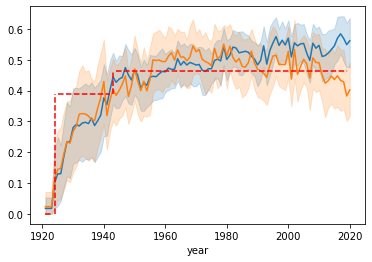

In [70]:
#picture
import seaborn as sns
import matplotlib.pyplot as plt
cnt=0
# for i in all_group_answers:
#     if 3 in i['突变点位置'] and 22 in i['突变点位置'] :
#         print(1)
#         data=one_year_stop_revolution
#         print(one_year_stop_revolution.columns[cnt+1])
#         if one_year_stop_revolution.columns[cnt+1] != 'tempo':
#             sns.lineplot(data=data,x='year',y=one_year_stop_revolution.columns[cnt+1])
#     cnt+=1
data=one_year_stop_revolution
lst=['danceability','valence']
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
p1=sns.lineplot(data=data,x='year',y='danceability',markers=True, dashes=False)
p2=sns.lineplot(data=data,x='year',y='valence', markers=True, dashes=False)
plt.plot([1921,1923],[(np.mean(data['danceability'][0:3])+np.mean(data['valence'][0:3]))/2,(np.mean(data['danceability'][0:3])+np.mean(data['valence'][0:3]))/2],'m--',color='r')
plt.plot([1925,1942],[(np.mean(data['danceability'][4:22])+np.mean(data['valence'][4:22]))/2,(np.mean(data['danceability'][4:22])+np.mean(data['valence'][4:22]))/2],'m--',color='r')
plt.plot([1944,2019],[(np.mean(data['danceability'][23:99])+np.mean(data['valence'][23:99]))/2,(np.mean(data['danceability'][23:99])+np.mean(data['valence'][23:99]))/2],'m--',color='r')
plt.plot([1924,1924],[(np.mean(data['danceability'][0:3])+np.mean(data['valence'][0:3]))/2,(np.mean(data['danceability'][4:22])+np.mean(data['valence'][4:22]))/2],'m--',color='r')
plt.plot([1943,1943],[(np.mean(data['danceability'][4:22])+np.mean(data['valence'][4:22]))/2,(np.mean(data['danceability'][23:99])+np.mean(data['valence'][23:99]))/2],'m--',color='r')
plt.ylabel('')
fig=plt.gcf()
# fig.savefig('pic.png')
fig.savefig('pic/6.png')

# plt.legend([p1,p2],['danceability','valence'])
# plt.legend(loc='lower right')
# 1924,1943,2020



# plt.plot(list(one_year_stop_revolution['valence']))
# plt.plot(list(one_year_stop_revolution['acousticness']))
# plt.plot(list(one_year_stop_revolution['artists_num_danceability']))
# duration_ms	energy	explicit	instrumentalness	key	liveness	loudness	mode	music_num	popularity	speechiness	tempo

In [63]:
# ten year stop to process data for revelution calculate
ten_year_stop_df=pd.read_csv(r'datanew/genre_ten_year_stop5_5.csv')
ten_year_stop_revolution=ten_year_stop_df
ten_year_stop_revolution.insert(0,'ten_year_revolution','')
columns=list(ten_year_stop_revolution.columns)
# NaN in first line of each genre should be replaced by 0
for index,row in ten_year_stop_revolution.iterrows():
    if row['decade']==1920:
        for i in range(2,len(columns)):
            if pd.isnull(ten_year_stop_revolution.iloc[[index],[i]].values[0]):
                ten_year_stop_revolution.iloc[[index],[i]]=0
#avoid SettingwithCopyWarning
nan2zerolist=['artists_num','music_num','influence_decade','influence_people','influence_genre']
# feature about influence should be replaced by 0
for index in nan2zerolist:
    ten_year_stop_revolution[index].fillna(0,inplace=True)
nan2padlist=['acousticness','danceability','duration_ms','energy','explicit','instrumentalness','key','liveness','loudness','mode','popularity','speechiness','tempo','valence']
#feature about music should be replaced by last one
for index in nan2padlist:
    ten_year_stop_revolution[index].fillna(method='pad',inplace=True)
ten_year_stop_revolution.head()

,ten_year_revolution,music_genre,decade,acousticness,artists_num,danceability,duration_ms,energy,explicit,influence_decade,...,instrumentalness,key,liveness,loudness,mode,music_num,popularity,speechiness,tempo,valence
0,,None,1920,0.982858,5.0,0.349189,279401.608491,0.130194,0.0,0.0,...,0.849255,5.683962,0.171307,-22.092377,0.627358,424.0,0.396226,0.042396,95.720993,0.236003
1,,None,1930,0.972419,6.0,0.350339,342101.338710,0.195621,0.0,0.0,...,0.538394,5.258065,0.350776,-19.853565,0.709677,62.0,6.983871,0.084519,100.652548,0.237947
2,,None,1940,0.949058,13.0,0.358379,238765.844660,0.171148,0.0,0.0,...,0.596992,5.038835,0.211884,-21.371951,0.728155,103.0,3.932039,0.045301,102.274087,0.294798
3,,None,1950,0.847306,22.0,0.424230,215722.070423,0.241043,0.0,0.0,...,0.449084,5.300469,0.181023,-19.005746,0.661972,213.0,8.014085,0.053500,103.223901,0.371313
4,,None,1960,0.698145,44.0,0.474800,214567.183206,0.354087,0.0,0.0,...,0.313173,5.057252,0.169983,-16.952649,0.690840,262.0,24.133588,0.053808,113.094050,0.516658


In [64]:
# ten year stop to get revolution
ten_year_stop_revolution=ten_year_stop_revolution.set_index(['music_genre','decade'])
genre_group_ten=ten_year_stop_revolution.groupby('music_genre')
all_group_answers=[]
for name,group in genre_group_ten:
    if name=="['Vocal']":
        for colname,column in group.iteritems():
            if colname!='ten_year_revolution':
                answer=trend_desc(column)
                all_group_answers.append(answer.copy())
        change_point_times=np.zeros(100)
        for answer in all_group_answers:
            for point in answer['突变点位置']:
                if point!='-':
                    change_point_times[point]=change_point_times[point]+1
        for i in range(len(change_point_times)):
            revolutiontime=10*i+1920
            ten_year_stop_revolution.loc[(name,revolutiontime),'ten_year_revolution']=change_point_times[i]
            if change_point_times[i]>=4:
                print('{} is revolution, its {} features are judged as revolution'.format(revolutiontime,int(change_point_times[i])))
print(all_group_answers)


D:\programfliesD\Anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
D:\programfliesD\Anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in true_divide


1960 is revolution, its 4 features are judged as revolution
1970 is revolution, its 4 features are judged as revolution
[{'整体趋势': ['大波动大幅下降'], '整体变化角度': [-39.88], '突变点个数': [1], '突变点位置': [4], 'Mann-Kendall突变位置': [1], 'Pettitt突变位置': [4], 'Buishand_U突变位置': [4], 'SNHT突变位置': [4], '详情': [{'第一段趋势': {'变化角度': -45.0, '趋势': '下降'}, '第二段趋势': {'变化角度': -3.74, '趋势': '下降'}}]}, {'整体趋势': ['大波动小幅下降'], '整体变化角度': [-8.17], '突变点个数': [1], '突变点位置': [8], 'Mann-Kendall突变位置': [2, 9], 'Pettitt突变位置': [8], 'Buishand_U突变位置': [9], 'SNHT突变位置': [9], '详情': [{'第一段趋势': {'变化角度': 27.7, '趋势': '上升'}, '第二段趋势': {'变化角度': -45.0, '趋势': '下降'}}]}, {'整体趋势': ['大波动大幅下降'], '整体变化角度': [-23.05], '突变点个数': ['-'], '突变点位置': ['-'], 'Mann-Kendall突变位置': ['-'], 'Pettitt突变位置': ['-'], 'Buishand_U突变位置': ['-'], 'SNHT突变位置': ['-'], '详情': ['-']}, {'整体趋势': ['大波动大幅上升'], '整体变化角度': [42.6], '突变点个数': [1], '突变点位置': [5], 'Mann-Kendall突变位置': [5, 6, 10], 'Pettitt突变位置': [5], 'Buishand_U突变位置': [5], 'SNHT突变位置': [5], '详情': [{'第一段趋势': {'变化角度': 42.89, '趋势': '上升'}, '第二段趋势'